In [3]:
# !pip install lightning
# !pip install torchinfo
# !pip install kornia

# Semantic Segmentation

The main goal of this project is to tackle a problem of semantic segmentation, specifically the segmentation of road cracks.

Some code is already provided (mainly the data loading code). You can modify most of the code unless specifically stated that some section should not be changed.

In [4]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import segmentation
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import shutil
import random


# add more imports here

import torchmetrics

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer, LightningModule

from kornia.losses import FocalLoss, DiceLoss

RANDOM_SEED = 42

random.seed(RANDOM_SEED) # DO NOT CHANGE THIS
pl.seed_everything(RANDOM_SEED)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

## Loading the data

Let's start by loading the data. You can find the dataset [here](https://drive.google.com/file/d/13L-Xe5gZPEg3kNWh4sl0uxoVM4C4OlYL/view?usp=share_link).

Download the zip file and upload it to your google drive.

Let's now mount the drive and access the folder where you saved the dataset.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# # access the data
# datadir = '/content/drive/MyDrive/dataset.zip' # change this path to where you stored the dataset

# # unzip dataset
# shutil.unpack_archive(datadir)

%cd /content/drive/MyDrive/Colab Notebooks/Project5

/content/drive/MyDrive/Colab Notebooks/Project5


In [7]:
# DO NOT CHANGE THIS CELL
images_list = os.listdir('dataset/images')
random.shuffle(images_list)

train_list = images_list[:300]
val_list = images_list[300:350]
test_list = images_list[350:]

## Visualizing the data

In the following section, you can use the function ``` display_image_grid ``` to visualize the data.



In [8]:
# note that you can use this function to visualize your model's predictions
def display_image_grid(images_filenames, images_directory='dataset', predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        # read image and convert to RGB
        image = cv2.imread(os.path.join(images_directory, 'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # read mask
        mask = cv2.imread(os.path.join(images_directory, 'masks', image_filename), cv2.IMREAD_GRAYSCALE)
        mask[mask <= 127] = 0
        mask[mask > 127] = 1

        # plot
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[0]
            ax[i, 2].imshow(predicted_mask, cmap='gray')
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

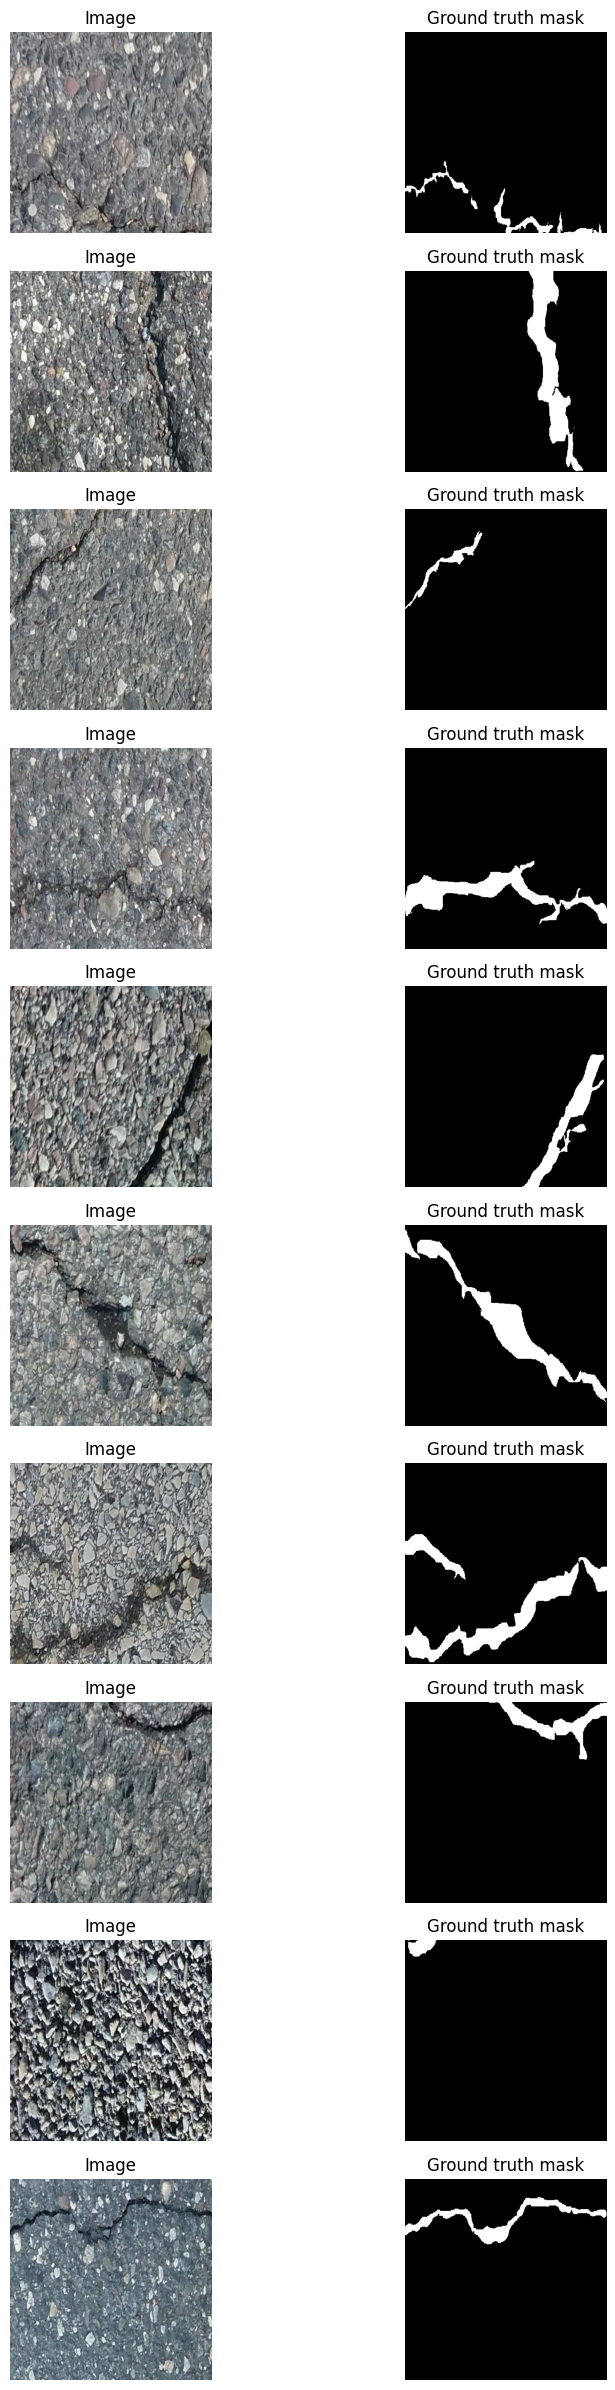

In [9]:
display_image_grid(train_list[:10], 'dataset')

## Building the Dataset

In [10]:
class RoadCracksDataset(Dataset):
    def __init__(self, images_list, images_directory='dataset', transform=None):
        self.images_list = images_list
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_filename = self.images_list[idx]
        image = cv2.imread(os.path.join(self.images_directory, 'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(self.images_directory, 'masks', image_filename), cv2.IMREAD_GRAYSCALE)
        mask[mask <= 127] = 0
        mask[mask > 127] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask.to(torch.int64)

## Defining the hyperparameters and model

Some hyperparameters have already been defined. Feel free to experiment and change them as you see fit.

In [11]:
# hyperparameters
nr_classes = 2 # this is a binary segmentation problem
batch_size = 8
num_workers = 8
epochs = 30
learning_rate = 1e-4

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# define transforms
transform = A.Compose(
    [
        A.Resize(520, 520),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
# feel free to add data augmentation if you see fit

In [13]:
# build the dataset and dataloaders
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset = RoadCracksDataset(train_list, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = RoadCracksDataset(val_list, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test_dataset = RoadCracksDataset(test_list, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

print("Size of Train DataLoader:", len(train_dataloader))
print("Size of Valid DataLoader:", len(val_dataloader))
print("Size of Test DataLoader:", len(test_dataloader))

Size of Train DataLoader: 38
Size of Valid DataLoader: 7
Size of Test DataLoader: 50


## Exercise 1

Finetune a pretrained segmentation model on the RoadCracks dataset using the standard cross entropy loss.

Measure the performance of your model **on the test set** in terms of:
*   pixel accuracy
*   Intersection over Union (IoU)

Plot some of the obtained segmentation results and compare them with the ground truth.




In [14]:
pl.seed_everything(RANDOM_SEED)

NUM_CLASSES = nr_classes

class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer_name, optimizer_hparams):
        """LightningModel.
        Args:
            model: Name of the model/CNN to run. Used for creating the model
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
         """
        super().__init__()

        self.model = model
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.classification.BinaryAccuracy()
        self.tain_iou = torchmetrics.classification.BinaryJaccardIndex()

        self.valid_acc = torchmetrics.classification.BinaryAccuracy()
        self.valid_iou = torchmetrics.classification.BinaryJaccardIndex()

        self.test_acc = torchmetrics.classification.BinaryAccuracy()
        self.test_iou = torchmetrics.classification.BinaryJaccardIndex()

    def configure_optimizers(self):
      # We will support Adam or SGD as optimizers.
      if self.hparams.optimizer_name == "Adam":
          optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
      elif self.hparams.optimizer_name == "SGD":
          optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
      else:
          assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

      # scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.002)
      # scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95), 'name': 'expo_lr'}
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)['out']

        loss = torch.nn.CrossEntropyLoss()(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.tain_iou.update(predicted_labels, true_labels)
        metrics = {'train_loss': loss, 'train_acc': self.train_acc, 'train_iou': self.tain_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.valid_acc.update(predicted_labels, true_labels)
        self.valid_iou.update(predicted_labels, true_labels)
        metrics = {'valid_loss': loss, 'valid_acc': self.valid_acc, 'valid_iou': self.valid_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc.update(predicted_labels, true_labels)
        self.test_iou.update(predicted_labels, true_labels)
        metrics = {'test_loss': loss, 'test_acc': self.test_acc, 'test_iou': self.test_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Model

In [16]:
weights = segmentation.FCN_ResNet50_Weights.DEFAULT
model = segmentation.fcn_resnet50(weights=weights, pretrained=True, progress=False)

model.classifier[4] = torch.nn.Conv2d(512, nr_classes, kernel_size=1, stride=1)
model.aux_classifier[4] = torch.nn.Conv2d(256, nr_classes, kernel_size=1, stride=1)

input_size =  (1, 3, 520, 520)
summary(model, input_size, device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [1, 2, 520, 520]          --
├─IntermediateLayerGetter: 1-1                [1, 2048, 65, 65]         --
│    └─Conv2d: 2-1                            [1, 64, 260, 260]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 260, 260]         128
│    └─ReLU: 2-3                              [1, 64, 260, 260]         --
│    └─MaxPool2d: 2-4                         [1, 64, 130, 130]         --
│    └─Sequential: 2-5                        [1, 256, 130, 130]        --
│    │    └─Bottleneck: 3-1                   [1, 256, 130, 130]        75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 130, 130]        70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 130, 130]        70,400
│    └─Sequential: 2-6                        [1, 512, 65, 65]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 65, 65]          379,392

In [17]:
pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": learning_rate, "betas": (0.9, 0.9), "eps": 0.00001, "weight_decay": 0.1, "amsgrad": False}

# optimizer_name = "SGD"
# optimizer_hparams = {'lr': learning_rate, 'momentum': 0.8, 'dampening': 0.2, 'weight_decay': 0.001, 'nesterov': False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

arch = 'fcn_resnet50'

cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./CrossEntropyLoss/checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

logger_csv = CSVLogger(save_dir="CrossEntropyLoss/logs/", name="my-model")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [18]:
pl.seed_everything(RANDOM_SEED)

PERCENT_VALID_EXAMPLES = 1
EPOCHS = epochs
LOG_EVERY_N_STEPS = 1

trainer = pl.Trainer(
    limit_val_batches = PERCENT_VALID_EXAMPLES,
    max_epochs = EPOCHS,
    logger=logger_csv,
    callbacks = cbs,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable

)

# trainer.fit(model_light, train_dataloaders = train_dataloader, val_dataloaders=val_dataloader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


### Load the model from the checkpoint

In [19]:
# If you are working in GPU, please, you do not run: device = torch.device('cpu')
device = torch.device('cpu')
checkpoint_file = '/content/drive/MyDrive/Colab Notebooks/Project5/CrossEntropyLoss/checkpoints_fcn_resnet50/fcn_resnet50.ckpt'

pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": learning_rate, "betas": (0.9, 0.9), "eps": 0.00001, "weight_decay": 0.1, "amsgrad": False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

checkpoint = torch.load(checkpoint_file, map_location=device)
model_light.load_state_dict(checkpoint['state_dict'])

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


<All keys matched successfully>

### Test DataLoad

In [21]:
# run test dataset
test_metrics = trainer.test(model_light, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.07199051231145859, 'test_acc': 0.9750093817710876, 'test_iou': 0.6158032417297363}]


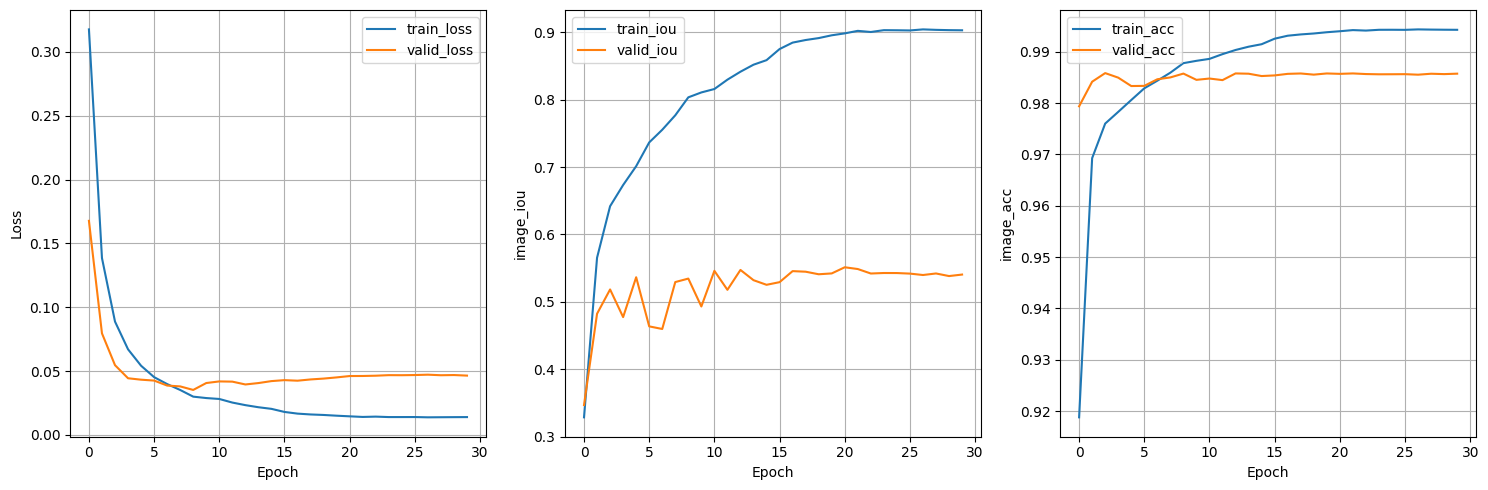

In [22]:
import pandas as pd

def printdf(df):
  return display(pd.DataFrame(df))

path = '/content/drive/MyDrive/Colab Notebooks/Project5/CrossEntropyLoss/logs/my-model/version_0'
metrics = pd.read_csv(f"{path}/metrics.csv")
metrics

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
# df_metrics

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
df_metrics[["train_loss", "valid_loss"]].plot(ax=axes[0], grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_iou", "valid_iou"]].plot(ax=axes[1], grid=True, legend=True, xlabel='Epoch', ylabel='image_iou')
df_metrics[["train_acc", "valid_acc"]].plot(ax=axes[2], grid=True, legend=True, xlabel='Epoch', ylabel='image_acc')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

## This cell must be run if it is the first time.

#### The results can called from the predict folder.

In [24]:
## It will take 10min more or less
pl.seed_everything(RANDOM_SEED)

target_list = []
predict_list = []
prob_predict_list = []

with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(test_dataloader):
        images, targets = batch
        logits = model(images)['out']

        prob_predict = logits.sigmoid()

        predict_prob0 = np.transpose(prob_predict[:,0,:,:].cpu().numpy(), (1, 2, 0)).flatten().reshape(-1, 1)
        predict_prob1 = np.transpose(prob_predict[:,1,:,:].cpu().numpy(), (1, 2, 0)).flatten().reshape(-1, 1)

        prob_predict_ = np.concatenate((predict_prob0, predict_prob1), axis=1)

        pr_masks = torch.argmax(logits, 1).unsqueeze(1)

        target = np.transpose(targets.cpu().numpy(), (1, 2, 0)).astype(int)
        target_predict = np.transpose(pr_masks[0].cpu().numpy(), (1, 2, 0)).astype(int)

        target_flatten = target.flatten().reshape(-1, 1)
        target_predict_flatten = target_predict.flatten().reshape(-1, 1)

        target_list.append(target_flatten)
        predict_list.append(target_predict_flatten)
        prob_predict_list.append(prob_predict_)

        # if idx == 3:
        #     break

target_ = np.vstack(target_list)
predict_ = np.vstack(predict_list)
prob_predict_ = np.vstack(prob_predict_list)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## It will call the results saved from the previous cell in folder

In [25]:
# %mkdir CrossEntropyLoss/predict

path = '/content/drive/MyDrive/Colab Notebooks/Project5/CrossEntropyLoss/predict'

# np.save(f'{path}/target.npy', target_)
# np.save(f'{path}/predict.npy', predict_)
# np.save(f'{path}/prob_predict.npy', prob_predict_)

target = np.load(f'{path}/target.npy')
predict = np.load(f'{path}/predict.npy')
prob_predict = np.load(f'{path}/prob_predict.npy')

print(target.shape)
print(predict.shape)
print(prob_predict.shape)

(13520000, 1)
(13520000, 1)
(13520000, 2)


In [26]:
from sklearn.metrics import confusion_matrix

# Assuming target_flatten and target_pred_flatten are your actual and predicted labels respectively
conf_matrix = confusion_matrix(target, predict)

print("Confusion Matrix:")
printdf(conf_matrix)

Confusion Matrix:


,0,1
0,12640573,124740
1,213133,541554


In [27]:
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(target, predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99  12765313
           1       0.81      0.72      0.76    754687

    accuracy                           0.98  13520000
   macro avg       0.90      0.85      0.87  13520000
weighted avg       0.97      0.98      0.97  13520000



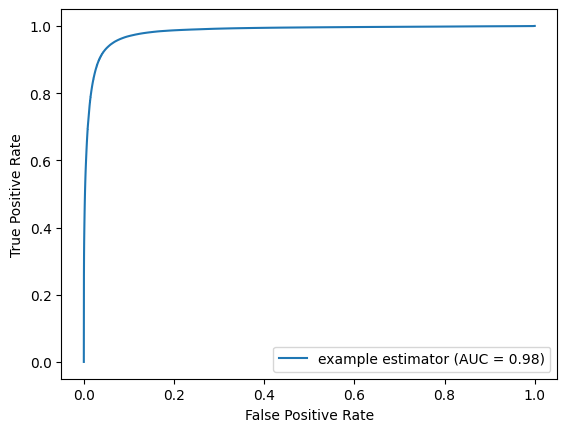

In [28]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(target, prob_predict[:,1])
roc_auc = auc(fpr, tpr)
Roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

Roc_display.plot()
plt.show()

In [30]:
pl.seed_everything(RANDOM_SEED)

def normalize(image):
    scaled_image = (image - np.min(image)) / (np.max(image) -  np.min(image))
    scaled_image *= 255
    return scaled_image.astype(np.uint8)

with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(test_dataloader):
        images, targets = batch
        logits = model(images)['out']

        pr_masks = torch.argmax(logits, 1).unsqueeze(1)

        img = normalize(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
        target = np.transpose(targets.cpu().numpy(), (1, 2, 0)).astype(np.uint8)
        target_pred = np.transpose(pr_masks[0].cpu().numpy(), (1, 2, 0)).astype(np.uint8)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(target)
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(target_pred)
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
        if idx == 10:
          break

Output hidden; open in https://colab.research.google.com to view.

How do both metrics (accuracy vs IoU) compare? Is one of them higher than the other? If so, why? Answer below.

In [31]:
### Write your answer here ###


# Accuracy has proven to be higher than IoU, mainly because it only considers the classification between 0 and 1.
# However, the data is imbalanced, so the high accuracy value may not be accurate to due the imbalance.

# On the other hand, the IoU metric considers the percentage of correctly segmented areas, which may provide values more in line with reality.

## Exercise 2

The dataset is clearly imbalanced, i.e. there are more background pixels than foreground pixels.

Is the cross entropy loss the best choice for this scenario?

Retrain your model using a loss that takes the class imbalance into account (e.g. Focal Loss). Take a look at the [PyTorch geometry](https://kornia.readthedocs.io/en/v0.1.2/losses.html) package for this purpose.

In [32]:
pl.seed_everything(RANDOM_SEED)

NUM_CLASSES = nr_classes

class LightningModel_loss(pl.LightningModule):
    def __init__(self, model, optimizer_name, optimizer_hparams):
        """LightningModel.
        Args:
            model: Name of the model/CNN to run. Used for creating the model
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
         """
        super().__init__()

        self.model = model
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.classification.BinaryAccuracy()
        self.tain_iou = torchmetrics.classification.BinaryJaccardIndex()

        self.valid_acc = torchmetrics.classification.BinaryAccuracy()
        self.valid_iou = torchmetrics.classification.BinaryJaccardIndex()

        self.test_acc = torchmetrics.classification.BinaryAccuracy()
        self.test_iou = torchmetrics.classification.BinaryJaccardIndex()

    def configure_optimizers(self):
      # We will support Adam or SGD as optimizers.
      if self.hparams.optimizer_name == "Adam":
          optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
      elif self.hparams.optimizer_name == "SGD":
          optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
      else:
          assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

      # scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.002)
      # scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95), 'name': 'expo_lr'}
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)['out']

        loss = FocalLoss(alpha=0.6, gamma=1.4, reduction='mean')(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.tain_iou.update(predicted_labels, true_labels)
        metrics = {'train_loss': loss, 'train_acc': self.train_acc, 'train_iou': self.tain_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.valid_acc.update(predicted_labels, true_labels)
        self.valid_iou.update(predicted_labels, true_labels)
        metrics = {'valid_loss': loss, 'valid_acc': self.valid_acc, 'valid_iou': self.valid_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc.update(predicted_labels, true_labels)
        self.test_iou.update(predicted_labels, true_labels)
        metrics = {'test_loss': loss, 'test_acc': self.test_acc, 'test_iou': self.test_iou}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [33]:
weights = segmentation.FCN_ResNet50_Weights.DEFAULT
model = segmentation.fcn_resnet50(weights=weights, pretrained=True, progress=False)

model.classifier[4] = torch.nn.Conv2d(512, nr_classes, kernel_size=1, stride=1)
model.aux_classifier[4] = torch.nn.Conv2d(256, nr_classes, kernel_size=1, stride=1)

input_size =  (1, 3, 520, 520)
summary(model, input_size, device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [1, 2, 520, 520]          --
├─IntermediateLayerGetter: 1-1                [1, 2048, 65, 65]         --
│    └─Conv2d: 2-1                            [1, 64, 260, 260]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 260, 260]         128
│    └─ReLU: 2-3                              [1, 64, 260, 260]         --
│    └─MaxPool2d: 2-4                         [1, 64, 130, 130]         --
│    └─Sequential: 2-5                        [1, 256, 130, 130]        --
│    │    └─Bottleneck: 3-1                   [1, 256, 130, 130]        75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 130, 130]        70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 130, 130]        70,400
│    └─Sequential: 2-6                        [1, 512, 65, 65]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 65, 65]          379,392

In [34]:
pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": learning_rate, "betas": (0.9, 0.9), "eps": 0.00001, "weight_decay": 0.1, "amsgrad": False}

# optimizer_name = "SGD"
# optimizer_hparams = {'lr': learning_rate, 'momentum': 0.8, 'dampening': 0.2, 'weight_decay': 0.001, 'nesterov': False}

model_light = LightningModel_loss(model, optimizer_name, optimizer_hparams)

arch = 'fcn_resnet50'

# /content/drive/MyDrive/Colab Notebooks/Project5/Loss_imbalance
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./Loss_imbalance/checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

logger_csv = CSVLogger(save_dir="Loss_imbalance/logs/", name="my-model")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [35]:
pl.seed_everything(RANDOM_SEED)

PERCENT_VALID_EXAMPLES = 1
EPOCHS = epochs
LOG_EVERY_N_STEPS = 1

trainer = pl.Trainer(
    limit_val_batches = PERCENT_VALID_EXAMPLES,
    max_epochs = EPOCHS,
    logger=logger_csv,
    callbacks = cbs,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable

)

# trainer.fit(model_light, train_dataloaders = train_dataloader, val_dataloaders=val_dataloader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


### Load the model from the checkpoint

In [36]:
# If you are working in GPU, please, you do not run: device = torch.device('cpu')
device = torch.device('cpu')
checkpoint_file = '/content/drive/MyDrive/Colab Notebooks/Project5/Loss_imbalance/checkpoints_fcn_resnet50/fcn_resnet50.ckpt'

pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": learning_rate, "betas": (0.9, 0.9), "eps": 0.00001, "weight_decay": 0.1, "amsgrad": False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

checkpoint = torch.load(checkpoint_file, map_location=device)
model_light.load_state_dict(checkpoint['state_dict'])

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


<All keys matched successfully>

### Test DataLoad

In [37]:
# run test dataset
test_metrics = trainer.test(model_light, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.1260823756456375, 'test_acc': 0.9717055559158325, 'test_iou': 0.6022651195526123}]


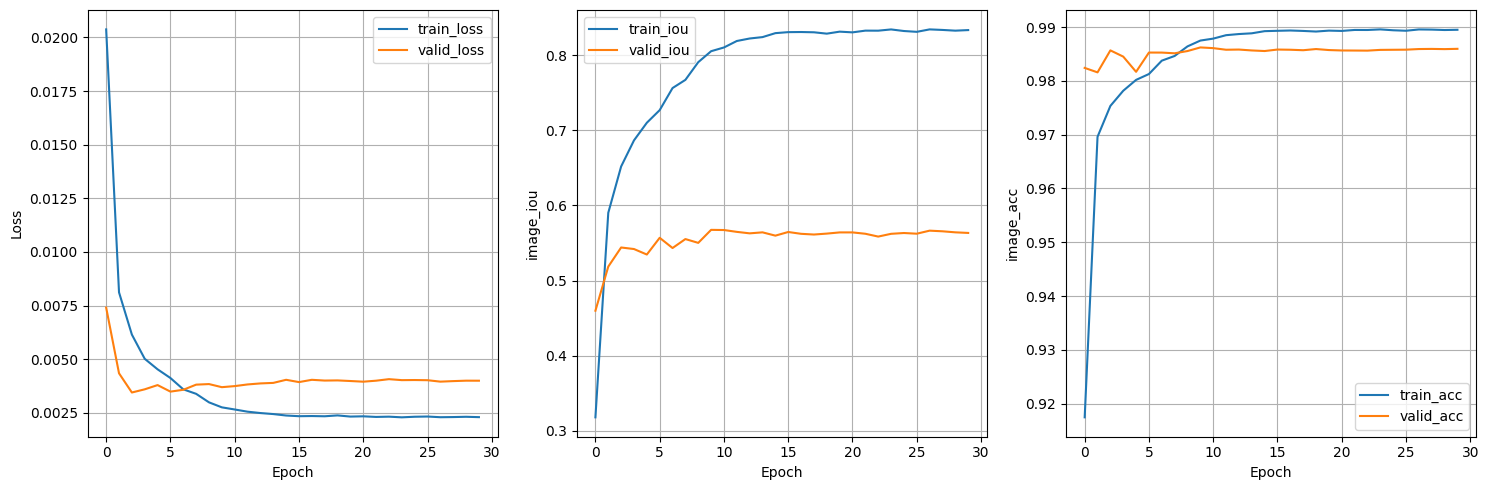

In [38]:
import pandas as pd

def printdf(df):
  return display(pd.DataFrame(df))

path = '/content/drive/MyDrive/Colab Notebooks/Project5/Loss_imbalance/logs/my-model/version_0'
metrics = pd.read_csv(f"{path}/metrics.csv")
metrics

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
# df_metrics

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
df_metrics[["train_loss", "valid_loss"]].plot(ax=axes[0], grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_iou", "valid_iou"]].plot(ax=axes[1], grid=True, legend=True, xlabel='Epoch', ylabel='image_iou')
df_metrics[["train_acc", "valid_acc"]].plot(ax=axes[2], grid=True, legend=True, xlabel='Epoch', ylabel='image_acc')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

## This cell must be run if it is the first time.

#### The results can called from the predict folder.


In [40]:
## It will take 10min more or less
pl.seed_everything(RANDOM_SEED)

target_list = []
predict_list = []
prob_predict_list = []

with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(test_dataloader):
        images, targets = batch
        logits = model(images)['out']

        prob_predict = logits.sigmoid()

        predict_prob0 = np.transpose(prob_predict[:,0,:,:].cpu().numpy(), (1, 2, 0)).flatten().reshape(-1, 1)
        predict_prob1 = np.transpose(prob_predict[:,1,:,:].cpu().numpy(), (1, 2, 0)).flatten().reshape(-1, 1)

        prob_predict_ = np.concatenate((predict_prob0, predict_prob1), axis=1)

        pr_masks = torch.argmax(logits, 1).unsqueeze(1)

        target = np.transpose(targets.cpu().numpy(), (1, 2, 0)).astype(int)
        target_predict = np.transpose(pr_masks[0].cpu().numpy(), (1, 2, 0)).astype(int)

        target_flatten = target.flatten().reshape(-1, 1)
        target_predict_flatten = target_predict.flatten().reshape(-1, 1)

        target_list.append(target_flatten)
        predict_list.append(target_predict_flatten)
        prob_predict_list.append(prob_predict_)

        # if idx == 3:
        #     break

target_ = np.vstack(target_list)
predict_ = np.vstack(predict_list)
prob_predict_ = np.vstack(prob_predict_list)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## It will call the results saved from the previous cell in folder


In [41]:

# %mkdir Loss_imbalance/predict

path = '/content/drive/MyDrive/Colab Notebooks/Project5/Loss_imbalance/predict'

# np.save(f'{path}/target.npy', target_)
# np.save(f'{path}/predict.npy', predict_)
# np.save(f'{path}/prob_predict.npy', prob_predict_)

target = np.load(f'{path}/target.npy')
predict = np.load(f'{path}/predict.npy')
prob_predict = np.load(f'{path}/prob_predict.npy')

print(target.shape)
print(predict.shape)
print(prob_predict.shape)

(13520000, 1)
(13520000, 1)
(13520000, 2)


In [42]:
from sklearn.metrics import confusion_matrix

# Assuming target_flatten and target_pred_flatten are your actual and predicted labels respectively
conf_matrix = confusion_matrix(target, predict)

print("Confusion Matrix:")
printdf(conf_matrix)

Confusion Matrix:


,0,1
0,12558201,207112
1,175429,579258


In [43]:
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(target, predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98  12765313
           1       0.74      0.77      0.75    754687

    accuracy                           0.97  13520000
   macro avg       0.86      0.88      0.87  13520000
weighted avg       0.97      0.97      0.97  13520000



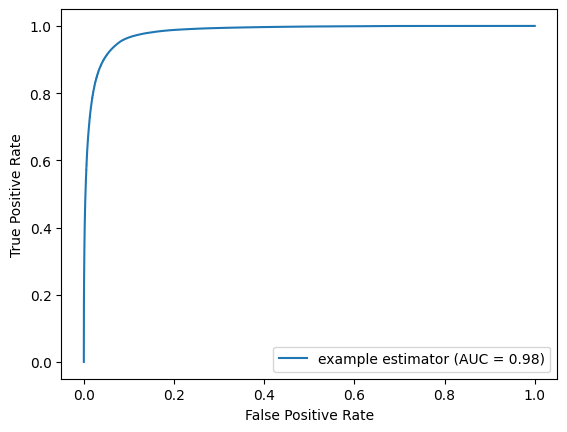

In [44]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(target, prob_predict[:,1])
roc_auc = auc(fpr, tpr)
Roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

Roc_display.plot()
plt.show()


In [46]:
pl.seed_everything(RANDOM_SEED)

def normalize(image):
    scaled_image = (image - np.min(image)) / (np.max(image) -  np.min(image))
    scaled_image *= 255
    return scaled_image.astype(np.uint8)

with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(test_dataloader):
        images, targets = batch
        logits = model(images)['out']

        pr_masks = torch.argmax(logits, 1).unsqueeze(1)

        img = normalize(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
        target = np.transpose(targets.cpu().numpy(), (1, 2, 0)).astype(np.uint8)
        target_pred = np.transpose(pr_masks[0].cpu().numpy(), (1, 2, 0)).astype(np.uint8)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(target)
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(target_pred)
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
        if idx == 10:
          break


Output hidden; open in https://colab.research.google.com to view.

Compare the performance of both models.

In [ ]:
### Write your answer here ###

# Even using FocalLoss as the loss function to try to minimize the impacts of imbalanced classes, the results of CrossEntropyLoss proved to be slightly better.

# Here, it might be the case to try other models with different geometry loss.
